In [941]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [942]:
dir_path = "~/movielens/ralf"
user_features_path = f"{dir_path}/user_features.csv"
movie_features_path = f"{dir_path}/movie_features.csv"
ratings_path = f"{dir_path}/ratings.csv"

In [943]:
def get_features(file_path):
    df = pd.read_csv(file_path)
    features = dict()
    for row in df.itertuples():
        features[row.id] = np.array(eval(row.features))
    return features 

In [944]:
def get_feature_update(features, row):
    features[row.user_id] = np.array(eval(row.user_features))

In [945]:
user_features = get_features(user_features_path)
movie_features = get_features(movie_features_path)

In [946]:
test_data = pd.read_csv(ratings_path)

In [947]:
experiment_path = "~/experiment_results/dest"
feature_updates = pd.read_csv(f"{experiment_path}/results_workers_1_least_learningrate_0.02_userfeaturereg_0.01.csv")

In [948]:
len(feature_updates)

49396

In [949]:
feature_updates

,user_id,user_features,timestamp
0,843,"[0.03497391266021731, -0.0930131896040979, 0.1...",1
1,454,"[0.015147542126658513, -0.11745682561262695, 0...",1
2,854,"[0.09761926144036312, -0.08534277076837851, 0....",1
3,334,"[0.1716856926028898, -0.10440537113820793, 0.2...",1
4,299,"[0.17201720458446304, -0.10451674686456212, 0....",1
...,...,...,...
49391,372,"[0.22111206966902006, -0.10296885119239266, 0....",494
49392,220,"[0.013205573138929439, -0.15819933661658347, 0...",494
49393,90,"[0.10473016330576834, -0.1811403809432033, 0.3...",494
49394,655,"[0.15017344212998535, -0.11060208119841283, 0....",494


In [950]:
len(test_data[test_data['timestamp'] == 0])

99

In [951]:
len(feature_updates[feature_updates['timestamp'] == 494])

16636

In [952]:
len(feature_updates)

49396

In [953]:
max(feature_updates['timestamp'])

494

In [954]:
def predict_rating(user_feature, movie_feature):
    return user_feature.dot(movie_feature.T)

def compute_test_mse(user_features, movie_features):
    predictions = []
    ratings = []
    count = 0
    for row in test_data.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
        ratings.append(rating) 
    mse = mean_squared_error(ratings, predictions)
    return mse

def compute_mse(user_features):
    predictions = []
    ratings = []
    for row in test_data.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        ratings.append(rating)
        predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
    return mean_squared_error(ratings, predictions)

def compute_improvement():
    count = 0
    predictions = []
    ratings = []
    max_timestamp = max(feature_updates['timestamp'])
    print(max_timestamp, len(feature_updates), len(test_data))
    baseline = compute_mse(user_features)
    while count <= max_timestamp:
        feature_update_ts = feature_updates[feature_updates['timestamp'] == count] 
        for row in feature_update_ts.itertuples():
            user_features[row.user_id] = np.array(eval(row.user_features))
        query_ts = test_data[test_data['timestamp'] == count]
        for row in query_ts.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
            ratings.append(rating)
        count += 1
    new_mse = mean_squared_error(ratings, predictions)
    optimal = compute_mse(user_features)
    return baseline, new_mse, optimal

In [955]:
mse = compute_improvement()
print(mse)
#(0.9647940328755866, 0.9036804990152152, 0.8395786686201222) .02 learning least

494 49396 49442
(0.9647940328755866, 0.9046417805481645, 0.8403843673418364)


In [956]:
def plot_learning_curve(mse):
        """visualize the training/testing loss"""
        linewidth = 3
        plt.plot(mse, label = 'Ralf', linewidth = linewidth)
        plt.xlabel('iterations')
        plt.ylabel('MSE')
        plt.legend(loc = 'best')

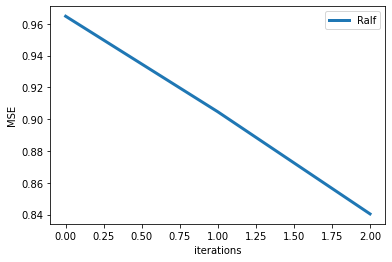

In [957]:
plot_learning_curve(mse)